In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import seaborn as sns
import time 
import pickle 
import warnings
from tqdm import tqdm
from PIL import Image
from datetime import datetime

In [3]:
print(cpu_use)

6


In [4]:
with open("btc_usd_1d.pkl", "rb") as f:
    df = pickle.load(f)
    df.reset_index(drop=True, inplace=True)

In [5]:
df

,o,h,l,c,v
0,376.42,386.60,372.25,376.72,2.746157e+06
1,376.57,381.99,373.32,373.34,1.145567e+06
2,376.40,382.31,373.03,378.39,2.520662e+06
3,378.39,382.86,375.23,379.25,2.593576e+06
4,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...
2609,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2610,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2611,36447.37,36825.98,34000.00,35091.11,4.510372e+03
2612,35084.79,36574.47,34624.59,36293.62,2.533704e+03


In [6]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()

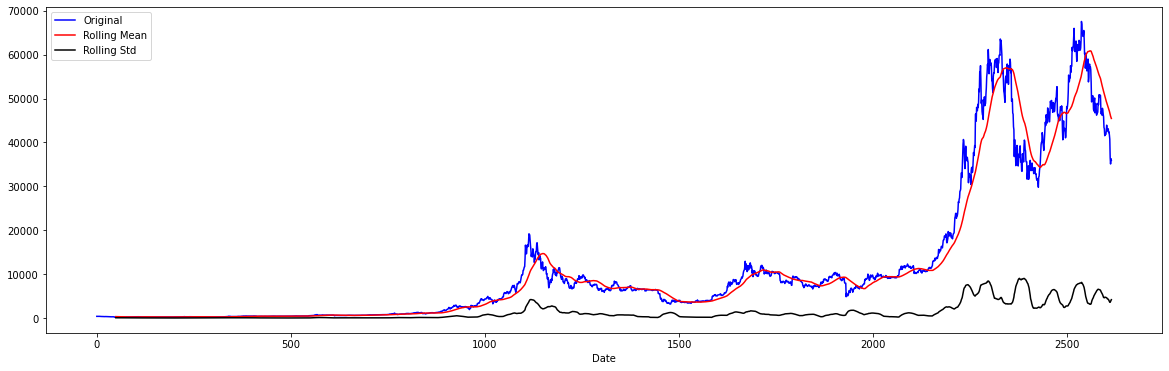

In [7]:
plot_rolling(df['c'], 50)

In [8]:
import pandas as pd 
import numpy as np
import FinanceDataReader as fdr
import os 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

import warnings
warnings.filterwarnings('ignore')

### 다우지수 불러오기

In [9]:
start_date = '20150104'
end_date = '20211214'
DJI_df = fdr.DataReader('dji', start_date, end_date).reset_index()
DJI_df

,Date,Close,Open,High,Low,Volume,Change
0,2015-01-05,17501.65,17821.30,17821.30,17475.93,116160000.0,-0.0186
1,2015-01-06,17371.64,17504.18,17581.05,17262.37,101870000.0,-0.0074
2,2015-01-07,17584.52,17374.78,17597.08,17374.78,91030000.0,0.0123
3,2015-01-08,17907.87,17591.97,17916.04,17591.97,114890000.0,0.0184
4,2015-01-09,17737.37,17911.02,17915.32,17686.09,93390000.0,-0.0095
...,...,...,...,...,...,...,...
1745,2021-12-08,35754.75,35716.85,35840.52,35602.65,387650000.0,0.0010
1746,2021-12-09,35754.69,35722.26,35864.24,35577.14,353020000.0,-0.0000
1747,2021-12-10,35970.99,35830.55,35982.69,35710.43,361200000.0,0.0060
1748,2021-12-13,35650.95,35958.93,35958.93,35609.53,451590000.0,-0.0089


### 원/달러 환율 정보 추가

In [10]:
EXC = fdr.DataReader('USD/KRW', start_date, end_date).reset_index()
EXC

,Date,Close,Open,High,Low,Change
0,2015-01-05,1109.93,1106.90,1112.60,1105.16,0.0027
1,2015-01-06,1099.00,1109.93,1110.20,1096.75,-0.0098
2,2015-01-07,1098.74,1099.00,1103.95,1095.10,-0.0002
3,2015-01-08,1095.51,1098.74,1102.00,1094.89,-0.0029
4,2015-01-09,1085.82,1095.51,1097.10,1085.32,-0.0088
...,...,...,...,...,...,...
1807,2021-12-08,1175.19,1176.85,1179.31,1175.12,-0.0013
1808,2021-12-09,1178.15,1173.42,1179.37,1172.62,0.0025
1809,2021-12-10,1180.86,1178.27,1182.82,1176.40,0.0023
1810,2021-12-13,1184.91,1180.96,1186.16,1177.03,0.0034


### 먼저 날짜 기준이 가지고 있는 데이터에 존재하지 않음 따라서 추가 지표는 추후 추가를 하는 것으로 하고 일단 가지고 있는 데이터 안에서 preprocessing

In [12]:
def preprocessing(price_df, len_lag) :
    # 이동평균선 추가 5,10,20
    moving_avg=[5,10,20]
    for i in moving_avg:
        price_df[f'{i}_close']=-1
    for index in range(len(price_df)):
        for i in moving_avg:
            price_df[f'{i}_close']=price_df['c'].rolling(window=i).mean()
        
    # p_lag:과거 가격, q_lag:과거 거래량 추가, pq_lag:거래대금 
    for lag in range(1,len_lag+1):
        price_df[f'p_lag_{lag}'] = -1
        price_df[f'q_lag_{lag}'] = -1 
        price_df[f'pq_lag_{lag}'] = -1
        for index in range(lag, len(price_df)):
            price_df.loc[index, f'p_lag_{lag}'] = price_df['c'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            price_df.loc[index, f'q_lag_{lag}'] = price_df['v'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
            price_df.loc[index, f'pq_lag_{lag}'] = (price_df['c'][index-lag]*price_df['v'][index-lag]) #1일전, 2일전, ... 거래량을 feature로 추가

In [13]:
def OBV_preprocessing(price_df):
    # OBV 산출 및 데이터 프레임에 추가 
    OBV=[]
    OBV.append(0)
    for i in range(1,len(price_df)):
        if price_df['c'].iloc[i] > price_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]+price_df['v'].iloc[i])
        elif price_df['c'].iloc[i]<price_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]-price_df['v'].iloc[i]) 
        else:
            OBV.append(OBV[-1])
            
    # OBV 추가
    price_df['obv']=OBV
    
    # 지수 평균 이동값 계산 
    price_df['obv_ema']=price_df['obv'].ewm(com=20).mean()
    
    # obv가 보통 지수를 위로 뚫으면 매수 신호 아래로 뚫으면 매도 신호 
    price_df['signal_obv']=price_df['obv']-price_df['obv_ema']
    
    moving_avg=[5,20,30]
    for i in moving_avg:
        price_df[f'obv_lag{i}']=-1
    for index in range(len(price_df)):
        for i in moving_avg:
            price_df[f'obv_lag{i}']=price_df['signal_obv'].rolling(window=i).mean()

In [14]:
def gen_train_test(price_df):
    price_df['target']=0
    for i in range(len(price_df)-1):
        price_df['target'].iloc[i]=price_df['c'].iloc[i+1]

In [15]:
price_df=df

In [16]:
OBV_preprocessing(price_df)

In [17]:
price_df.head(30)

,o,h,l,c,v,obv,obv_ema,signal_obv,obv_lag5,obv_lag20,obv_lag30
0,376.42,386.60,372.25,376.72,2746157.05,0.00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
1,376.57,381.99,373.32,373.34,1145566.61,-1145566.61,-5.867536e+05,-5.588130e+05,NaN,NaN,NaN
2,376.40,382.31,373.03,378.39,2520662.37,1375095.76,9.934913e+04,1.275747e+06,NaN,NaN,NaN
3,378.39,382.86,375.23,379.25,2593576.46,3968672.22,1.138582e+06,2.830090e+06,NaN,NaN,NaN
4,379.25,383.00,374.23,376.67,2998357.92,970314.30,1.101567e+06,-1.312531e+05,6.831541e+05,NaN,NaN
5,376.67,378.99,360.01,365.20,3297896.46,-2327582.16,4.581366e+05,-2.785719e+06,1.260103e+05,NaN,NaN
6,365.20,377.89,363.99,374.95,3331762.49,1004180.33,5.480101e+05,4.561702e+05,3.290070e+05,NaN,NaN
7,374.95,376.99,371.31,375.07,861748.71,1865929.04,7.422109e+05,1.123718e+06,2.986013e+05,NaN,NaN
8,375.07,377.50,373.16,376.87,913715.62,2779644.66,1.015208e+06,1.764437e+06,8.547068e+04,NaN,NaN
9,376.87,377.45,364.60,364.61,3655238.40,-875593.74,7.820007e+05,-1.657594e+06,-2.197976e+05,NaN,NaN


In [18]:
preprocessing(price_df,10)

In [19]:
gen_train_test(price_df)

In [20]:
price_df

,o,h,l,c,v,obv,obv_ema,signal_obv,obv_lag5,obv_lag20,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
0,376.42,386.60,372.25,376.72,2.746157e+06,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,373.34
1,376.57,381.99,373.32,373.34,1.145567e+06,-1.145567e+06,-5.867536e+05,-5.588130e+05,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,378.39
2,376.40,382.31,373.03,378.39,2.520662e+06,1.375096e+06,9.934913e+04,1.275747e+06,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,379.25
3,378.39,382.86,375.23,379.25,2.593576e+06,3.968672e+06,1.138582e+06,2.830090e+06,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,376.67
4,379.25,383.00,374.23,376.67,2.998358e+06,9.703143e+05,1.101567e+06,-1.312531e+05,683154.075048,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,365.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,41733.21,43518.69,40554.14,40736.05,2.425153e+03,-3.382900e+08,-3.382809e+08,-9.102960e+03,-7379.717331,-9386.120289,...,43933.50,2502.762101,1.099551e+08,42736.00,2442.654151,1.043893e+08,41845.42,3494.013786,1.462085e+08,36495.46
2610,40654.72,41115.58,35423.00,36495.46,6.201046e+03,-3.382962e+08,-3.382816e+08,-1.457524e+04,-8878.214846,-9812.785245,...,42571.94,1993.883243,8.488348e+07,43933.50,2502.762101,1.099551e+08,42736.00,2442.654151,1.043893e+08,35091.11
2611,36447.37,36825.98,34000.00,35091.11,4.510372e+03,-3.383007e+08,-3.382825e+08,-1.817678e+04,-10962.567299,-10400.479367,...,43102.35,1386.832758,5.977575e+07,42571.94,1993.883243,8.488348e+07,43933.50,2502.762101,1.099551e+08,36293.62
2612,35084.79,36574.47,34624.59,36293.62,2.533704e+03,-3.382982e+08,-3.382833e+08,-1.489817e+04,-12777.220469,-10785.241241,...,43102.01,707.658523,3.050150e+07,43102.35,1386.832758,5.977575e+07,42571.94,1993.883243,8.488348e+07,35917.44


In [21]:
final_price_df=price_df.drop(['o','h','l'],axis=1)

In [22]:
final_price_df

,c,v,obv,obv_ema,signal_obv,obv_lag5,obv_lag20,obv_lag30,5_close,10_close,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
0,376.72,2.746157e+06,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,373.34
1,373.34,1.145567e+06,-1.145567e+06,-5.867536e+05,-5.588130e+05,NaN,NaN,NaN,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,378.39
2,378.39,2.520662e+06,1.375096e+06,9.934913e+04,1.275747e+06,NaN,NaN,NaN,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,379.25
3,379.25,2.593576e+06,3.968672e+06,1.138582e+06,2.830090e+06,NaN,NaN,NaN,NaN,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,376.67
4,376.67,2.998358e+06,9.703143e+05,1.101567e+06,-1.312531e+05,683154.075048,NaN,NaN,376.874,NaN,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,365.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,40736.05,2.425153e+03,-3.382900e+08,-3.382809e+08,-9.102960e+03,-7379.717331,-9386.120289,-8000.593101,42031.886,42560.523,...,43933.50,2502.762101,1.099551e+08,42736.00,2442.654151,1.043893e+08,41845.42,3494.013786,1.462085e+08,36495.46
2610,36495.46,6.201046e+03,-3.382962e+08,-3.382816e+08,-1.457524e+04,-8878.214846,-9812.785245,-8323.960532,40709.438,41936.469,...,42571.94,1993.883243,8.488348e+07,43933.50,2502.762101,1.099551e+08,42736.00,2442.654151,1.043893e+08,35091.11
2611,35091.11,4.510372e+03,-3.383007e+08,-3.382825e+08,-1.817678e+04,-10962.567299,-10400.479367,-8829.571742,39276.646,41052.230,...,43102.35,1386.832758,5.977575e+07,42571.94,1993.883243,8.488348e+07,43933.50,2502.762101,1.099551e+08,36293.62
2612,36293.62,2.533704e+03,-3.382982e+08,-3.382833e+08,-1.489817e+04,-12777.220469,-10785.241241,-9184.763599,38059.890,40424.398,...,43102.01,707.658523,3.050150e+07,43102.35,1386.832758,5.977575e+07,42571.94,1993.883243,8.488348e+07,35917.44


In [23]:
train_df=final_price_df.iloc[29:2550]
test_df=final_price_df.iloc[2550:2613]
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [24]:
print(train_df.shape)
print(test_df.shape)

(2521, 42)
(63, 42)


In [25]:
X_train=train_df.drop('target',axis=1,inplace=False)
y_train=train_df['target']
#x_train=X_train[:1500]
#x_valid=X_train[1500:]
#y_train=y_train[:1500]
#y_valid=y_train[1500:]
X_test=test_df.drop('target',axis=1,inplace=False)
y_test=test_df['target']

In [26]:
X_train

,c,v,obv,obv_ema,signal_obv,obv_lag5,obv_lag20,obv_lag30,5_close,10_close,...,pq_lag_7,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10
0,316.63,1.288907e+06,-9.248138e+06,-7.216944e+06,-2.031194e+06,-2.304153e+06,-4.456353e+06,-2.893676e+06,320.986,324.208,...,6.833678e+08,329.99,3.617197e+06,1.193639e+09,318.00,4.999168e+06,1.589735e+09,312.17,6.788858e+06,2.119278e+09
1,314.78,1.859592e+06,-1.110773e+07,-7.454586e+06,-3.653143e+06,-2.629265e+06,-4.239098e+06,-3.015448e+06,319.514,323.886,...,1.262959e+09,323.15,2.114708e+06,6.833678e+08,329.99,3.617197e+06,1.193639e+09,318.00,4.999168e+06,1.589735e+09
2,311.94,3.091942e+06,-1.419967e+07,-7.861093e+06,-6.338578e+06,-3.283105e+06,-4.096250e+06,-3.208107e+06,318.024,322.081,...,8.737214e+08,330.52,3.821126e+06,1.262959e+09,323.15,2.114708e+06,6.833678e+08,329.99,3.617197e+06,1.193639e+09
3,319.25,1.925335e+06,-1.227434e+07,-8.123744e+06,-4.150592e+06,-3.925552e+06,-4.153105e+06,-3.388984e+06,315.698,321.691,...,5.883775e+08,335.49,2.604314e+06,8.737214e+08,330.52,3.821126e+06,1.262959e+09,323.15,2.114708e+06,6.833678e+08
4,316.31,1.018388e+06,-1.329272e+07,-8.427756e+06,-4.864968e+06,-4.207695e+06,-4.388805e+06,-3.645486e+06,315.782,320.270,...,4.009373e+08,322.14,1.826465e+06,5.883775e+08,335.49,2.604314e+06,8.737214e+08,330.52,3.821126e+06,1.262959e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,60373.65,3.716811e+03,-3.382601e+08,-3.382564e+08,-3.701971e+03,-3.803405e+03,1.772776e+03,4.575271e+03,62809.888,64245.533,...,2.219741e+08,66945.72,2.136858e+03,1.430535e+08,67559.00,2.715424e+03,1.834513e+08,63300.00,1.115669e+03,7.062184e+07
2517,56917.66,6.160710e+03,-3.382663e+08,-3.382569e+08,-9.393030e+03,-5.113645e+03,7.814447e+02,3.746767e+03,61309.916,63181.399,...,1.026306e+08,64921.43,3.419119e+03,2.219741e+08,66945.72,2.136858e+03,1.430535e+08,67559.00,2.715424e+03,1.834513e+08
2518,58128.55,3.277026e+03,-3.382630e+08,-3.382572e+08,-5.824765e+03,-5.974990e+03,6.681212e+01,2.964266e+03,59833.652,62299.682,...,1.616348e+08,64821.33,1.583284e+03,1.026306e+08,64921.43,3.419119e+03,2.219741e+08,66945.72,2.136858e+03,1.430535e+08
2519,59768.54,1.172159e+03,-3.382618e+08,-3.382574e+08,-4.431053e+03,-6.190940e+03,-4.842528e+02,2.379780e+03,59066.142,61784.393,...,5.347498e+07,64158.41,2.519307e+03,1.616348e+08,64821.33,1.583284e+03,1.026306e+08,64921.43,3.419119e+03,2.219741e+08


In [27]:
y_train

0         314.78
1         311.94
2         319.25
3         316.31
4         316.51
          ...   
2516    56917.66
2517    58128.55
2518    59768.54
2519    58678.47
2520    56294.11
Name: target, Length: 2521, dtype: float64

In [28]:
import xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
pred = xgb.predict(X_test)

In [30]:
pred

array([58289.14 , 53095.035, 58185.637, 56821.086, 54496.49 , 55474.008,
       57628.72 , 57487.418, 57241.05 , 58210.094, 59402.227, 54955.777,
       51079.203, 51024.62 , 51113.465, 49996.586, 50974.062, 47953.414,
       48163.543, 51625.07 , 49879.445, 46515.953, 48140.67 , 48638.82 ,
       47150.84 , 45937.9  , 47711.723, 45075.31 , 45856.77 , 48639.06 ,
       49017.906, 50115.96 , 50793.88 , 50621.32 , 48054.664, 44300.625,
       47918.87 , 45393.797, 45050.277, 45320.27 , 47517.875, 47245.777,
       45352.508, 46266.05 , 43088.203, 42802.01 , 42354.707, 42680.387,
       42103.67 , 39923.28 , 40937.215, 46857.94 , 42959.85 , 43557.38 ,
       42447.85 , 42870.69 , 42151.676, 42411.15 , 43039.22 , 39745.605,
       36062.67 , 36696.41 , 36859.504], dtype=float32)

In [31]:
y_test

0     57579.99
1     57185.06
2     58990.14
3     53789.35
4     54774.66
        ...   
58    40736.05
59    36495.46
60    35091.11
61    36293.62
62    35917.44
Name: target, Length: 63, dtype: float64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

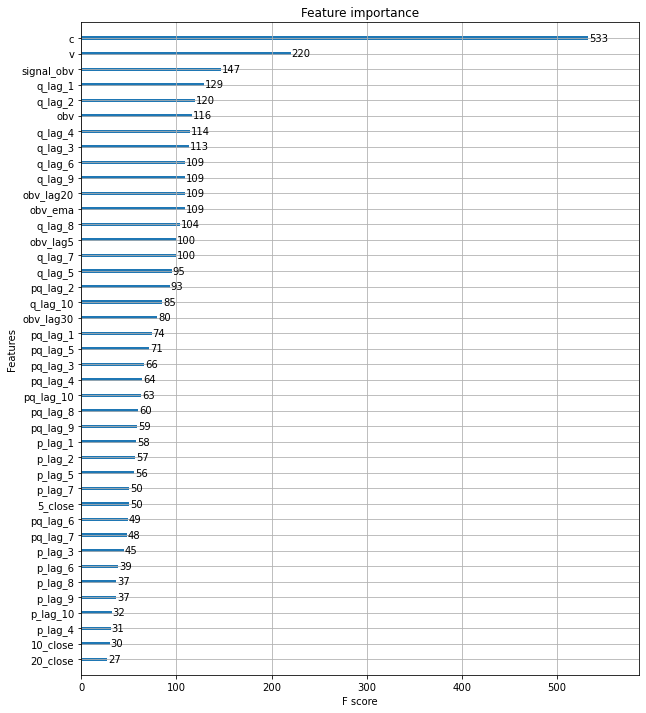

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb, ax=ax)

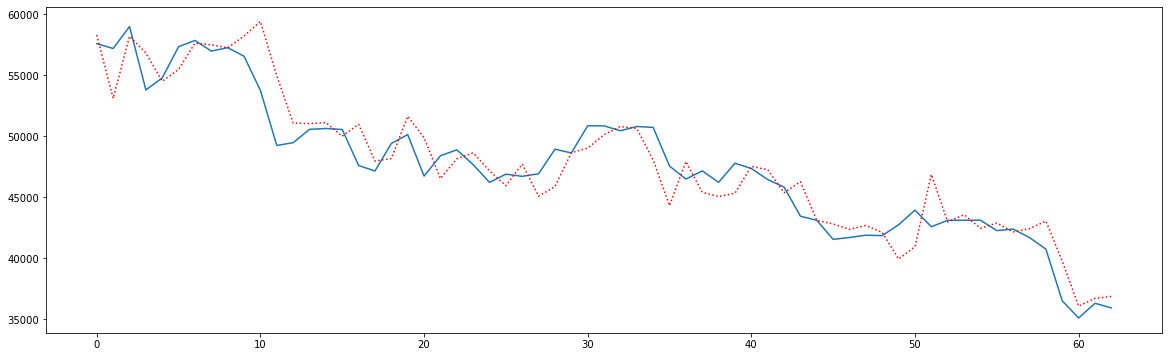

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(y_test)
plt.plot(pred, color='red', linestyle=":")

In [37]:
pred

array([58289.14 , 53095.035, 58185.637, 56821.086, 54496.49 , 55474.008,
       57628.72 , 57487.418, 57241.05 , 58210.094, 59402.227, 54955.777,
       51079.203, 51024.62 , 51113.465, 49996.586, 50974.062, 47953.414,
       48163.543, 51625.07 , 49879.445, 46515.953, 48140.67 , 48638.82 ,
       47150.84 , 45937.9  , 47711.723, 45075.31 , 45856.77 , 48639.06 ,
       49017.906, 50115.96 , 50793.88 , 50621.32 , 48054.664, 44300.625,
       47918.87 , 45393.797, 45050.277, 45320.27 , 47517.875, 47245.777,
       45352.508, 46266.05 , 43088.203, 42802.01 , 42354.707, 42680.387,
       42103.67 , 39923.28 , 40937.215, 46857.94 , 42959.85 , 43557.38 ,
       42447.85 , 42870.69 , 42151.676, 42411.15 , 43039.22 , 39745.605,
       36062.67 , 36696.41 , 36859.504], dtype=float32)

In [38]:
y_test

0     57579.99
1     57185.06
2     58990.14
3     53789.35
4     54774.66
        ...   
58    40736.05
59    36495.46
60    35091.11
61    36293.62
62    35917.44
Name: target, Length: 63, dtype: float64

In [35]:
diff = np.mean(np.abs(pred-y_test)/y_test)

In [36]:
diff

0.0313220206846656

### 데이터 정규화 처리 

In [39]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(X_train)
x_test_scaled=scaler.fit_transform(X_test)

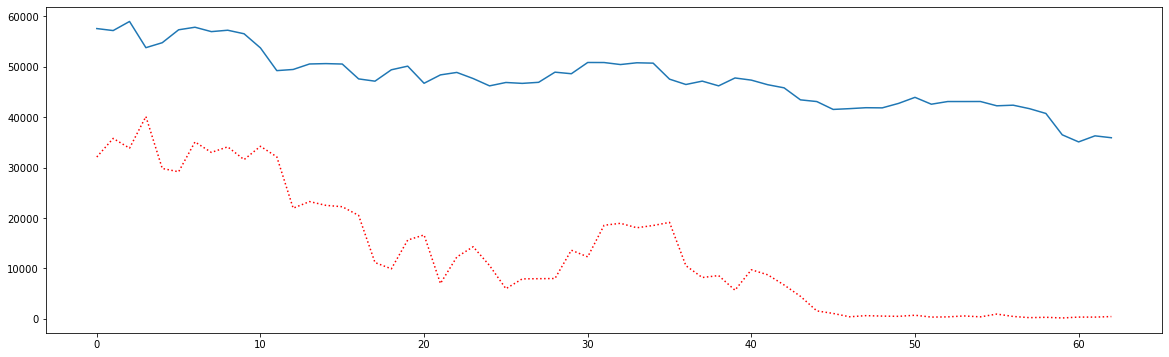

In [40]:
xgb.fit(x_train_scaled, y_train)
pred=xgb.predict(x_test_scaled)
plt.figure(figsize=(20, 6))
plt.plot(y_test)
plt.plot(pred, color='red', linestyle=":")

In [41]:
pred

array([32096.354  , 35783.57   , 33853.812  , 40126.668  , 29821.926  ,
       29164.027  , 35085.992  , 33006.37   , 34107.547  , 31576.652  ,
       34220.71   , 32127.412  , 21938.121  , 23248.922  , 22499.004  ,
       22228.777  , 20507.691  , 11150.985  ,  9906.31   , 15616.631  ,
       16627.93   ,  6995.0176 , 12249.096  , 14291.446  , 10564.185  ,
        5961.2817 ,  7909.9565 ,  7948.11   ,  7983.091  , 13600.902  ,
       12279.318  , 18549.72   , 18936.068  , 18055.518  , 18504.176  ,
       19117.822  , 10528.503  ,  8182.016  ,  8565.097  ,  5661.705  ,
        9719.252  ,  8724.283  ,  6703.2593 ,  4452.535  ,  1558.1155 ,
        1051.5951 ,   392.41782,   614.6289 ,   526.8907 ,   478.5959 ,
         695.324  ,   328.41818,   369.4798 ,   554.4044 ,   377.28595,
         926.5881 ,   455.08957,   215.12587,   288.11163,   153.06088,
         330.84497,   325.48224,   431.66623], dtype=float32)

In [42]:
y_test

0     57579.99
1     57185.06
2     58990.14
3     53789.35
4     54774.66
        ...   
58    40736.05
59    36495.46
60    35091.11
61    36293.62
62    35917.44
Name: target, Length: 63, dtype: float64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

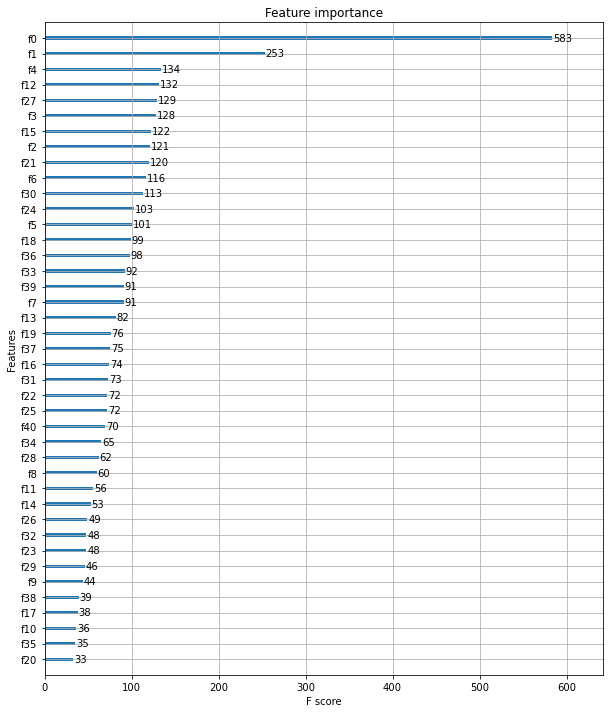

In [43]:
fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb, ax=ax)